In [1]:
import time
inicio = time.time()

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.under_sampling import ClusterCentroids
# el muestreo aleatorio simple sin reemplazamiento no sirve porque no capta la variabilidad de la clase minoritaria.
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import LeaveOneOut

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# Se importan los datos

In [3]:
df = pd.read_excel("..//Base_datos_Clasificacion binaria.xlsx", index_col = 0)

In [4]:
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,MP,Empresa sancionada,UTE
0,0,1738093.21,1484428.72,6,1,0
1,0,469670.24,272492.00,4,0,0
2,0,1025088.19,707310.85,1,0,0
3,0,999890.00,497621.36,6,0,0
4,0,72598.27,47508.92,1,1,0
...,...,...,...,...,...,...
2211,1,5542028.88,5514320.00,6,1,0
2212,1,6095782.00,5100555.00,6,1,0
2213,1,3752906.00,3744400.00,6,1,0
2214,1,23896564.00,19547338.00,6,0,1


In [5]:
n_clase0 = len(df[df["Licitacion reparto"] == 0])
n_clase0

1851

In [6]:
n_clase1 = len(df[df["Licitacion reparto"] == 1])
n_clase1

365

# Se trata el desbalanceo de clases mediante una tecnica de Infra - Muestreo. Hay que instalar la libreria imbalanced - learn

In [7]:
y = df["Licitacion reparto"]
X = df[df.columns[1:]]

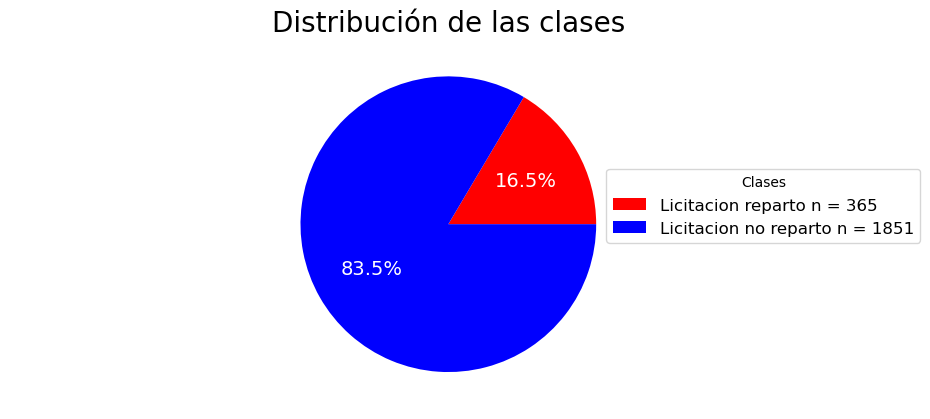

In [8]:
datos = [len(y[y == 1]), len(y[y == 0])]
etiquetas = [f'Licitacion reparto n = {n_clase1}', f'Licitacion no reparto n = {n_clase0}']
colores = ['red', 'blue']

plt.pie(datos, labels = etiquetas, colors = colores, autopct = '%1.1f%%', textprops = {'fontsize': 14, 'color': 'white'})
plt.title('Distribución de las clases', fontsize = 20)
plt.legend(title = "Clases", bbox_to_anchor=(1.8, 0.55), loc='right', fontsize = 12)
plt.show()

# Codificacion OneHotEncoder

In [9]:
codificador = OneHotEncoder()

In [10]:
df[["MP", "Empresa sancionada", "UTE"]] = df[["MP", "Empresa sancionada", "UTE"]].astype("float")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2215
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Licitacion reparto     2216 non-null   int64  
 1   Importe presupuestado  2216 non-null   float64
 2   Importe adjudicado     2216 non-null   float64
 3   MP                     2216 non-null   float64
 4   Empresa sancionada     2216 non-null   float64
 5   UTE                    2216 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 121.2 KB


In [11]:
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,MP,Empresa sancionada,UTE
0,0,1738093.21,1484428.72,6.0,1.0,0.0
1,0,469670.24,272492.00,4.0,0.0,0.0
2,0,1025088.19,707310.85,1.0,0.0,0.0
3,0,999890.00,497621.36,6.0,0.0,0.0
4,0,72598.27,47508.92,1.0,1.0,0.0
...,...,...,...,...,...,...
2211,1,5542028.88,5514320.00,6.0,1.0,0.0
2212,1,6095782.00,5100555.00,6.0,1.0,0.0
2213,1,3752906.00,3744400.00,6.0,1.0,0.0
2214,1,23896564.00,19547338.00,6.0,0.0,1.0


In [12]:
codificacion = codificador.fit_transform(df[["MP"]])

mercados = pd.DataFrame(codificacion.toarray(),
                        columns = ["MP1", "MP4", "MP6"])
df.drop("MP", axis = 1, inplace = True)
df.reset_index(inplace = True, drop = True)
df = pd.concat([df, mercados], axis = 1)
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,Empresa sancionada,UTE,MP1,MP4,MP6
0,0,1738093.21,1484428.72,1.0,0.0,0.0,0.0,1.0
1,0,469670.24,272492.00,0.0,0.0,0.0,1.0,0.0
2,0,1025088.19,707310.85,0.0,0.0,1.0,0.0,0.0
3,0,999890.00,497621.36,0.0,0.0,0.0,0.0,1.0
4,0,72598.27,47508.92,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2211,1,5542028.88,5514320.00,1.0,0.0,0.0,0.0,1.0
2212,1,6095782.00,5100555.00,1.0,0.0,0.0,0.0,1.0
2213,1,3752906.00,3744400.00,1.0,0.0,0.0,0.0,1.0
2214,1,23896564.00,19547338.00,0.0,1.0,0.0,0.0,1.0


In [13]:
y = df["Licitacion reparto"]
X = df[df.columns[1:]]

In [14]:
nombre_clases = ["Licitacion no reparto", "Licitacion reparto"]
nombre_predicciones = list(map(lambda x : x + " predicho", nombre_clases))

### Se utiliza la técnica "ClusterCentroids" que reemplaza las observaciones por un centroide dado por los k vecinos más cercanos.

In [15]:
# conda install -c conda-forge imbalanced-learn
cc = ClusterCentroids(random_state=123)
X_res, y_res = cc.fit_resample(X, y)
df = pd.concat([y_res, X_res], axis = 1)
df

,Licitacion reparto,Importe presupuestado,Importe adjudicado,Empresa sancionada,UTE,MP1,MP4,MP6
0,0,6.776405e+04,6.312591e+04,0.287037,0.037037,0.083333,0.009259,0.907407
1,0,3.563140e+08,2.915613e+08,0.000000,1.000000,0.000000,0.000000,1.000000
2,0,6.513581e+07,6.513581e+07,0.000000,0.000000,1.000000,0.000000,0.000000
3,0,6.407947e+08,5.119260e+08,0.000000,1.000000,0.000000,0.000000,1.000000
4,0,2.458220e+07,2.428981e+07,1.000000,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
725,1,5.542029e+06,5.514320e+06,1.000000,0.000000,0.000000,0.000000,1.000000
726,1,6.095782e+06,5.100555e+06,1.000000,0.000000,0.000000,0.000000,1.000000
727,1,3.752906e+06,3.744400e+06,1.000000,0.000000,0.000000,0.000000,1.000000
728,1,2.389656e+07,1.954734e+07,0.000000,1.000000,0.000000,0.000000,1.000000


In [16]:
n_clase0 = len(df[df["Licitacion reparto"] == 0])
n_clase0

365

In [17]:
n_clase1 = len(df[df["Licitacion reparto"] == 1])
n_clase1

365

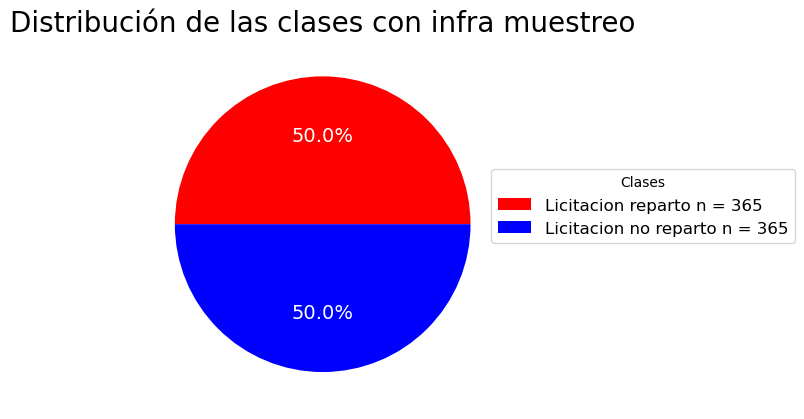

In [18]:
datos = [len(y_res[y_res == 1]), len(y_res[y_res == 0])]
etiquetas = [f'Licitacion reparto n = {n_clase1}', f'Licitacion no reparto n = {n_clase0}']
colores = ['red', 'blue']

plt.pie(datos, labels = etiquetas, colors = colores, autopct = '%1.1f%%', textprops = {'fontsize': 14, 'color': 'white'})
plt.title('Distribución de las clases con infra muestreo', fontsize = 20)
plt.legend(title = "Clases", bbox_to_anchor=(1.8, 0.55), loc='right', fontsize = 12)
plt.show()